In [11]:
#FedProx
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import copy
import os
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======================
# (CIFAR-10)
# ======================
def load_cifar10_data(num_clients=100, iid_degree=0.1):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    targets = np.array(full_dataset.targets)

    client_data = {i: {'x': [], 'y': []} for i in range(num_clients)}

    # Dirichlet
    for class_idx in range(10):
        class_indices = np.where(targets == class_idx)[0]
        np.random.shuffle(class_indices)

        proportions = np.random.dirichlet(np.repeat(iid_degree, num_clients))
        allocations = (proportions * len(class_indices)).astype(int)
        allocations[-1] = len(class_indices) - np.sum(allocations[:-1])

        start_idx = 0
        for client_id in range(num_clients):
            end_idx = start_idx + allocations[client_id]
            client_indices = class_indices[start_idx:end_idx]

            for idx in client_indices:
                img, label = full_dataset[idx]
                client_data[client_id]['x'].append(img)
                client_data[client_id]['y'].append(label)

            start_idx = end_idx

    client_loaders = {}
    for client_id, data in client_data.items():
        if len(data['x']) == 0:
            continue

        x_train, x_test, y_train, y_test = train_test_split(
            data['x'], data['y'], test_size=0.2, random_state=42
        )

        train_dataset = CustomDataset(x_train, y_train)
        test_dataset = CustomDataset(x_test, y_test)

        client_loaders[client_id] = {
            'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
            'test': DataLoader(test_dataset, batch_size=32, shuffle=False)
        }

    return client_loaders

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# ======================
# (CNN for CIFAR-10)
# ======================
class CifarCNN(nn.Module):
    def __init__(self):
        super(CifarCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4*4*128, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ======================
# FedProx client
# ======================
class FedProxClient:
    def __init__(self, client_id, train_loader, test_loader, device):
        self.client_id = client_id
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.model = CifarCNN().to(device)
        self.criterion = nn.CrossEntropyLoss()

    def train(self, global_model, mu, local_epochs, lr=0.01):
        self.model.load_state_dict(global_model.state_dict())
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=lr)

        train_loss, correct, total = 0.0, 0, 0

        for epoch in range(local_epochs):
            epoch_loss = 0.0
            for data, targets in self.train_loader:
                data, targets = data.to(self.device), targets.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(data)
                loss = self.criterion(outputs, targets)

                prox_term = 0.0
                for w, w_t in zip(self.model.parameters(), global_model.parameters()):
                    prox_term += (w - w_t).norm(2)

                loss += (mu / 2) * prox_term
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

            epoch_loss /= len(self.train_loader)
            train_loss += epoch_loss

        train_loss /= local_epochs
        train_acc = 100. * correct / total

        return copy.deepcopy(self.model.state_dict()), train_loss, train_acc

    def test(self, model=None):
        if model:
            self.model.load_state_dict(model)
        self.model.eval()

        test_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for data, targets in self.test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                loss = self.criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_loss /= len(self.test_loader)
        test_acc = 100. * correct / total
        return test_loss, test_acc

# ======================
# FedProx server
# ======================
class FedProxServer:
    def __init__(self, num_clients, device, mu=0.1, dynamic_mu=False):
        self.global_model = CifarCNN().to(device)
        self.device = device
        self.clients = []
        self.mu = mu
        self.dynamic_mu = dynamic_mu
        self.num_clients = num_clients

    def add_clients(self, client_loaders):
        for client_id, loaders in client_loaders.items():
            self.clients.append(FedProxClient(client_id, loaders['train'], loaders['test'], self.device))

    def aggregate(self, client_updates):
        global_dict = self.global_model.state_dict()
        total_samples = sum([samples for _, samples, _ in client_updates])
        averaged_params = {key: torch.zeros_like(global_dict[key]) for key in global_dict.keys()}

        for model_state, samples, _ in client_updates:
            for key in model_state.keys():
                averaged_params[key] += model_state[key] * (samples / total_samples)

        self.global_model.load_state_dict(averaged_params)

    def select_clients(self, fraction=0.1):
        num_selected = max(int(self.num_clients * fraction), 1)
        return np.random.choice(self.clients, num_selected, replace=False)

    def adaptive_mu(self, round_idx, base_mu=0.1, decay_rate=0.98):
        if self.dynamic_mu:
            return base_mu * (decay_rate ** round_idx)
        return self.mu

    def evaluate_global_model(self, test_loader=None):
        self.global_model.eval()
        if test_loader:
            return self._centralized_eval(test_loader)
        else:
            return self._federated_eval()

    def _centralized_eval(self, test_loader):
        correct, total, test_loss = 0, 0, 0.0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.global_model(data)
                loss = F.cross_entropy(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_loss /= len(test_loader)
        test_acc = 100. * correct / total
        return test_loss, test_acc

    def _federated_eval(self):
        total_loss, total_acc, total_samples = 0.0, 0.0, 0
        for client in self.clients:
            samples = len(client.test_loader.dataset)
            loss, acc = client.test(self.global_model.state_dict())
            total_loss += loss * samples
            total_acc += acc * samples
            total_samples += samples

        avg_loss = total_loss / total_samples
        avg_acc = total_acc / total_samples
        return avg_loss, avg_acc

# ======================
# main function
# ======================
def main():
    num_rounds = 100
    num_clients = 100
    client_fraction = 0.1
    local_epochs = 5
    base_mu = 0.1
    dynamic_mu = True

    print("Loading CIFAR-10 data...")
    client_loaders = load_cifar10_data(num_clients=num_clients, iid_degree=0.1)

    server = FedProxServer(num_clients=num_clients, device=device, mu=base_mu, dynamic_mu=dynamic_mu)
    server.add_clients(client_loaders)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    history = {'round': [], 'mu': [], 'global_loss': [], 'global_acc': [], 'client_losses': [], 'client_accs': []}

    print("Starting Federated Training...")
    for round_idx in range(num_rounds):
        mu = server.adaptive_mu(round_idx, base_mu=base_mu)
        selected_clients = server.select_clients(fraction=client_fraction)
        print(f"Round {round_idx+1}/{num_rounds}, μ={mu:.4f}, Clients: {len(selected_clients)}")

        client_updates = []
        client_stats = {'loss': [], 'acc': []}

        for client in selected_clients:
            model_state, loss, acc = client.train(global_model=server.global_model, mu=mu, local_epochs=local_epochs, lr=0.01)
            samples = len(client.train_loader.dataset)
            client_updates.append((model_state, samples, client.client_id))
            client_stats['loss'].append(loss)
            client_stats['acc'].append(acc)

        server.aggregate(client_updates)
        global_loss, global_acc = server.evaluate_global_model(test_loader=test_loader)

        history['round'].append(round_idx)
        history['mu'].append(mu)
        history['global_loss'].append(global_loss)
        history['global_acc'].append(global_acc)
        history['client_losses'].append(client_stats['loss'])
        history['client_accs'].append(client_stats['acc'])

        print(f"Global Test - Loss: {global_loss:.4f}, Acc: {global_acc:.2f}%")
        print(f"Client Avg - Loss: {np.mean(client_stats['loss']):.4f}, Acc: {np.mean(client_stats['acc']):.2f}%")

    torch.save({'model': server.global_model.state_dict(), 'history': history}, 'fedprox_cifar10_results.pth')
    print("Training complete! Results saved.")

if __name__ == "__main__":
    main()


Loading CIFAR-10 data...
Starting Federated Training...
Round 1/100, μ=0.1000, Clients: 10
Global Test - Loss: 2.4402, Acc: 10.00%
Client Avg - Loss: 1.8985, Acc: 51.37%
Round 2/100, μ=0.0980, Clients: 10
Global Test - Loss: 2.5416, Acc: 10.00%
Client Avg - Loss: 1.2902, Acc: 55.22%
Round 3/100, μ=0.0960, Clients: 10
Global Test - Loss: 2.6278, Acc: 10.00%
Client Avg - Loss: 1.0257, Acc: 66.94%
Round 4/100, μ=0.0941, Clients: 10
Global Test - Loss: 2.4116, Acc: 11.52%
Client Avg - Loss: 0.9354, Acc: 70.47%
Round 5/100, μ=0.0922, Clients: 10
Global Test - Loss: 2.5837, Acc: 14.91%
Client Avg - Loss: 0.8185, Acc: 72.79%
Round 6/100, μ=0.0904, Clients: 10
Global Test - Loss: 2.8051, Acc: 16.47%
Client Avg - Loss: 0.8501, Acc: 74.35%
Round 7/100, μ=0.0886, Clients: 10
Global Test - Loss: 2.4822, Acc: 10.44%
Client Avg - Loss: 0.6559, Acc: 78.79%
Round 8/100, μ=0.0868, Clients: 10
Global Test - Loss: 2.3783, Acc: 17.17%
Client Avg - Loss: 0.8471, Acc: 71.94%
Round 9/100, μ=0.0851, Clients: 

In [12]:
#FedAVG
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy
import random

# -----------------------------
# 1. Model Definition (CIFAR-10 CNN)
# -----------------------------
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*128, 256),
            nn.ReLU(),
            nn.Linear(256, 10)  # CIFAR-10 has 10 classes
        )

    def forward(self, x):
        return self.fc(self.conv(x))

# -----------------------------
# 2. CIFAR-10 Partitioning (Non-IID)
# -----------------------------
def partition_data(dataset, num_clients=100):
    labels = np.array(dataset.targets)
    idx_by_class = [np.where(labels == i)[0] for i in range(10)]
    client_indices = [[] for _ in range(num_clients)]
    for c in range(10):
        np.random.shuffle(idx_by_class[c])
        parts = np.array_split(idx_by_class[c], num_clients)
        for i in range(num_clients):
            client_indices[i].extend(parts[i])
    return [Subset(dataset, inds) for inds in client_indices]

# -----------------------------
# 3. Client Class (FedAvg)
# -----------------------------
class Client:
    def __init__(self, model, data, lr, local_epochs, device):
        self.model = copy.deepcopy(model)
        self.data = data
        self.lr = lr
        self.local_epochs = local_epochs
        self.device = device

    def train(self, global_model):
        self.model.load_state_dict(global_model.state_dict())
        self.model.train()

        optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        loader = DataLoader(self.data, batch_size=32, shuffle=True)

        for epoch in range(self.local_epochs):
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                output = self.model(x)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()

        return copy.deepcopy(self.model.state_dict())
    
    def evaluate(self):
        self.model.eval()
        loader = DataLoader(self.data, batch_size=64, shuffle=False)
        criterion = nn.CrossEntropyLoss()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = criterion(output, y)
                total_loss += loss.item() * x.size(0)
                pred = output.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return total_loss / total, correct / total

# -----------------------------
# 4. Server Class (FedAvg)
# -----------------------------
class Server:
    def __init__(self, model, num_clients):
        self.global_model = model
        self.clients = []
        self.num_clients = num_clients

    def add_clients(self, client_list):
        self.clients = client_list

    def aggregate(self, client_states):
        avg_state = copy.deepcopy(self.global_model.state_dict())
        for k in avg_state:
            avg_state[k] = sum(client[k] for client in client_states) / len(client_states)
        self.global_model.load_state_dict(avg_state)

    def federated_train(self, rounds):
        for r in range(rounds):
            selected = random.sample(self.clients, k=10)
            client_states = []

            print(f"Round {r+1}/{rounds}, Clients: {len(selected)}")

            for client in selected:
                state_dict = client.train(self.global_model)
                client_states.append(state_dict)

            self.aggregate(client_states)

            # Evaluate on all clients
            global_losses, global_accs = [], []
            for client in self.clients:
                client.model.load_state_dict(self.global_model.state_dict())
                loss, acc = client.evaluate()
                global_losses.append(loss)
                global_accs.append(acc)

            avg_loss = np.mean(global_losses)
            avg_acc = np.mean(global_accs) * 100

            print(f"Global Test - Loss: {avg_loss:.4f}, Acc: {avg_acc:.2f}%")

# -----------------------------
# 5. Main Execution
# -----------------------------
def main():
    start_time = time.time()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    print("[0] Loading CIFAR-10...")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    cifar_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    print(f"[1] Dataset loaded. Total samples: {len(cifar_train)}")

    print("[2] Partitioning data...")
    partition_start = time.time()
    client_data = partition_data(cifar_train, num_clients=100)
    print(f"[3] Partition done in {time.time() - partition_start:.2f}s")

    print("[4] Initializing models...")
    global_model = CIFAR_CNN().to(device)
    server = Server(global_model, num_clients=100)
    clients = [Client(global_model, data, lr=0.01, local_epochs=2, device=device) for data in client_data]
    server.add_clients(clients)

    print("[5] Starting federated training...")
    server.federated_train(rounds=100)

    print(f"[6] Done. Total time: {time.time() - start_time:.2f}s")

if __name__ == '__main__':
    main()


Using device: cpu
[0] Loading CIFAR-10...
[1] Dataset loaded. Total samples: 50000
[2] Partitioning data...
[3] Partition done in 0.01s
[4] Initializing models...
[5] Starting federated training...
Round 1/100, Clients: 10
Global Test - Loss: 2.2901, Acc: 10.68%
Round 2/100, Clients: 10
Global Test - Loss: 2.2519, Acc: 21.40%
Round 3/100, Clients: 10
Global Test - Loss: 2.1130, Acc: 24.15%
Round 4/100, Clients: 10
Global Test - Loss: 2.0078, Acc: 29.17%
Round 5/100, Clients: 10
Global Test - Loss: 1.9378, Acc: 30.32%
Round 6/100, Clients: 10
Global Test - Loss: 1.8756, Acc: 32.77%
Round 7/100, Clients: 10
Global Test - Loss: 1.8225, Acc: 34.17%
Round 8/100, Clients: 10
Global Test - Loss: 1.7726, Acc: 36.28%
Round 9/100, Clients: 10
Global Test - Loss: 1.7000, Acc: 38.81%
Round 10/100, Clients: 10
Global Test - Loss: 1.6610, Acc: 39.96%
Round 11/100, Clients: 10
Global Test - Loss: 1.6117, Acc: 41.38%
Round 12/100, Clients: 10
Global Test - Loss: 1.5725, Acc: 43.74%
Round 13/100, Clien

In [13]:
#SCAFFOLD
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy
import random

# -----------------------------
# 1. Model Definition (CIFAR-10 CNN)
# -----------------------------
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*128, 256),
            nn.ReLU(),
            nn.Linear(256, 10)  # CIFAR-10 has 10 classes
        )

    def forward(self, x):
        return self.fc(self.conv(x))

# -----------------------------
# 2. Partitioning (Non-IID)
# -----------------------------
def partition_data(dataset, num_clients=100):
    labels = np.array(dataset.targets)
    idx_by_class = [np.where(labels == i)[0] for i in range(10)]
    client_indices = [[] for _ in range(num_clients)]
    for c in range(10):
        np.random.shuffle(idx_by_class[c])
        parts = np.array_split(idx_by_class[c], num_clients)
        for i in range(num_clients):
            client_indices[i].extend(parts[i])
    return [Subset(dataset, inds) for inds in client_indices]

# -----------------------------
# 3. Client Class (SCAFFOLD)
# -----------------------------
class Client:
    def __init__(self, model, data, lr, local_epochs, device):
        self.model = copy.deepcopy(model)
        self.data = data
        self.lr = lr
        self.local_epochs = local_epochs
        self.device = device
        self.ci = {k: torch.zeros_like(v) for k, v in self.model.state_dict().items()}

    def train(self, global_model, global_control):
        self.model.load_state_dict(global_model.state_dict())
        self.model.train()

        optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        loader = DataLoader(self.data, batch_size=32, shuffle=True)

        for epoch in range(self.local_epochs):
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                output = self.model(x)
                loss = criterion(output, y)

                # SCAFFOLD correction term
                control = torch.tensor(0.0, device=self.device)

                model_state = self.model.state_dict()
                global_state = global_model.state_dict()

                for name in model_state:
                    p = model_state[name]
                    w_t = global_state[name]
                    c = global_control[name]
                    ci = self.ci[name]
                    control += ((p - w_t) * (c - ci)).sum()

                loss += 0.5 * control
                loss.backward()
                optimizer.step()

        # Update local control variates
        delta_ci = {}
        with torch.no_grad():
            for k in self.model.state_dict().keys():
                delta = global_control[k] - self.ci[k] + \
                        (self.model.state_dict()[k] - global_model.state_dict()[k]) / (self.local_epochs * self.lr)
                delta_ci[k] = delta
                self.ci[k] += delta

        return copy.deepcopy(self.model.state_dict()), delta_ci

    def evaluate(self):
        self.model.eval()
        loader = DataLoader(self.data, batch_size=64, shuffle=False)
        criterion = nn.CrossEntropyLoss()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = criterion(output, y)
                total_loss += loss.item() * x.size(0)
                pred = output.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return total_loss / total, correct / total

# -----------------------------
# 4. Server Class (SCAFFOLD)
# -----------------------------
class Server:
    def __init__(self, model, num_clients):
        self.global_model = model
        self.clients = []
        self.num_clients = num_clients
        self.global_control = {k: torch.zeros_like(v) for k, v in self.global_model.state_dict().items()}

    def add_clients(self, client_list):
        self.clients = client_list

    def aggregate(self, client_states):
        avg_state = copy.deepcopy(self.global_model.state_dict())
        for k in avg_state:
            avg_state[k] = sum(client[k] for client in client_states) / len(client_states)
        self.global_model.load_state_dict(avg_state)

    def update_control(self, delta_controls):
        for k in self.global_control:
            self.global_control[k] += sum(delta[k] for delta in delta_controls) / len(delta_controls)

    def federated_train(self, rounds):
        for r in range(rounds):
            selected = random.sample(self.clients, k=10)
            client_states, delta_controls = [], []

            print(f"Round {r+1}/{rounds}, Clients: {len(selected)}")

            for client in selected:
                state_dict, delta_ci = client.train(self.global_model, self.global_control)
                client_states.append(state_dict)
                delta_controls.append(delta_ci)

            self.aggregate(client_states)
            self.update_control(delta_controls)

            # Evaluate
            global_losses, global_accs = [], []
            for client in self.clients:
                client.model.load_state_dict(self.global_model.state_dict())
                loss, acc = client.evaluate()
                global_losses.append(loss)
                global_accs.append(acc)

            avg_loss = np.mean(global_losses)
            avg_acc = np.mean(global_accs) * 100

            print(f"Global Test - Loss: {avg_loss:.4f}, Acc: {avg_acc:.2f}%")

# -----------------------------
# 5. Main Execution
# -----------------------------
def main():
    start_time = time.time()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    print("[0] Loading CIFAR-10...")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    cifar_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    print(f"[1] Dataset loaded. Total samples: {len(cifar_train)}")

    print("[2] Partitioning data...")
    partition_start = time.time()
    client_data = partition_data(cifar_train, num_clients=100)
    print(f"[3] Partition done in {time.time() - partition_start:.2f}s")

    print("[4] Initializing models...")
    global_model = CIFAR_CNN().to(device)
    server = Server(global_model, num_clients=100)
    clients = [Client(global_model, data, lr=0.01, local_epochs=2, device=device) for data in client_data]
    server.add_clients(clients)

    print("[5] Starting federated training...")
    server.federated_train(rounds=100)

    print(f"[6] Done. Total time: {time.time() - start_time:.2f}s")

if __name__ == '__main__':
    main()


Using device: cpu
[0] Loading CIFAR-10...
[1] Dataset loaded. Total samples: 50000
[2] Partitioning data...
[3] Partition done in 0.00s
[4] Initializing models...
[5] Starting federated training...
Round 1/100, Clients: 10
Global Test - Loss: 2.2893, Acc: 13.00%
Round 2/100, Clients: 10
Global Test - Loss: 2.2574, Acc: 16.93%
Round 3/100, Clients: 10
Global Test - Loss: 2.1325, Acc: 23.78%
Round 4/100, Clients: 10
Global Test - Loss: 2.0529, Acc: 28.44%
Round 5/100, Clients: 10
Global Test - Loss: 1.9654, Acc: 29.34%
Round 6/100, Clients: 10
Global Test - Loss: 1.9069, Acc: 31.72%
Round 7/100, Clients: 10
Global Test - Loss: 1.8411, Acc: 33.74%
Round 8/100, Clients: 10
Global Test - Loss: 1.7871, Acc: 35.58%
Round 9/100, Clients: 10
Global Test - Loss: 1.7370, Acc: 36.99%
Round 10/100, Clients: 10
Global Test - Loss: 1.7065, Acc: 38.21%
Round 11/100, Clients: 10
Global Test - Loss: 1.6460, Acc: 40.63%
Round 12/100, Clients: 10
Global Test - Loss: 1.6071, Acc: 42.00%
Round 13/100, Clien

In [14]:
# FedICT 

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
import copy
import random

# -----------------------------
# 1. Model Definition (CIFAR-10 CNN)
# -----------------------------
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*128, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.fc(self.conv(x))

# -----------------------------
# 2. Partitioning (Non-IID)
# -----------------------------
def partition_data(dataset, num_clients=100):
    labels = np.array(dataset.targets)
    idx_by_class = [np.where(labels == i)[0] for i in range(10)]
    client_indices = [[] for _ in range(num_clients)]
    for c in range(10):
        np.random.shuffle(idx_by_class[c])
        parts = np.array_split(idx_by_class[c], num_clients)
        for i in range(num_clients):
            client_indices[i].extend(parts[i])
    return [Subset(dataset, inds) for inds in client_indices]

# -----------------------------
# 3. Client Class (FedICT)
# -----------------------------
class Client:
    def __init__(self, model, data, lr, local_epochs, device):
        self.model = copy.deepcopy(model)
        self.data = data
        self.lr = lr
        self.local_epochs = local_epochs
        self.device = device

    def local_train(self):
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        loader = DataLoader(self.data, batch_size=32, shuffle=True)

        for epoch in range(self.local_epochs):
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                output = self.model(x)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()

        return copy.deepcopy(self.model.state_dict())

    def get_data_and_logits(self):
        self.model.eval()
        loader = DataLoader(self.data, batch_size=64, shuffle=False)
        x_all, logits_all, targets_all = [], [], []

        with torch.no_grad():
            for x, y in loader:
                x_device = x.to(self.device)
                logits = self.model(x_device)
                x_all.append(x.cpu())
                logits_all.append(logits.cpu())
                targets_all.append(y)

        x_all = torch.cat(x_all, dim=0)
        logits_all = torch.cat(logits_all, dim=0)
        targets_all = torch.cat(targets_all, dim=0)
        return x_all, logits_all, targets_all

    def evaluate(self):
        self.model.eval()
        loader = DataLoader(self.data, batch_size=64, shuffle=False)
        criterion = nn.CrossEntropyLoss()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = criterion(output, y)
                total_loss += loss.item() * x.size(0)
                pred = output.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return total_loss / total, correct / total

# -----------------------------
# 4. Server Class (FedICT)
# -----------------------------
class Server:
    def __init__(self, model, num_clients):
        self.global_model = model
        self.clients = []
        self.num_clients = num_clients

    def add_clients(self, client_list):
        self.clients = client_list

    def federated_train(self, rounds):
        for r in range(rounds):
            selected = random.sample(self.clients, k=10)
            client_states = []
            all_x, all_logits = [], []

            print(f"Round {r+1}/{rounds}, Clients: {len(selected)}")

            for client in selected:
                state_dict = client.local_train()
                client_states.append(state_dict)

                client.model.load_state_dict(state_dict)
                x_batch, logits, _ = client.get_data_and_logits()
                all_x.append(x_batch)
                all_logits.append(logits)

            concat_x = torch.cat(all_x, dim=0)
            concat_logits = torch.cat(all_logits, dim=0)
            pseudo_labels = concat_logits.softmax(dim=1)

            # Update global model using distillation
            self.global_model.train()
            optimizer = optim.SGD(self.global_model.parameters(), lr=0.001, momentum=0.9)
            loader = DataLoader(TensorDataset(concat_x, pseudo_labels), batch_size=64, shuffle=True)

            for x_batch, pseudo_y in loader:
                x_batch = x_batch.to(next(self.global_model.parameters()).device)
                pseudo_y = pseudo_y.to(next(self.global_model.parameters()).device)
                optimizer.zero_grad()
                output = self.global_model(x_batch)
                loss = nn.KLDivLoss(reduction="batchmean")(output.log_softmax(dim=1), pseudo_y)
                loss.backward()
                optimizer.step()

            # Evaluate
            global_losses, global_accs = [], []
            for client in self.clients:
                client.model.load_state_dict(self.global_model.state_dict())
                loss, acc = client.evaluate()
                global_losses.append(loss)
                global_accs.append(acc)

            avg_loss = np.mean(global_losses)
            avg_acc = np.mean(global_accs) * 100

            print(f"Global Test - Loss: {avg_loss:.4f}, Acc: {avg_acc:.2f}%")

# -----------------------------
# 5. Main Execution
# -----------------------------
def main():
    start_time = time.time()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    print("[0] Loading CIFAR-10...")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    cifar_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    print(f"[1] Dataset loaded. Total samples: {len(cifar_train)}")

    print("[2] Partitioning data...")
    partition_start = time.time()
    client_data = partition_data(cifar_train, num_clients=100)
    print(f"[3] Partition done in {time.time() - partition_start:.2f}s")

    print("[4] Initializing models...")
    global_model = CIFAR_CNN().to(device)
    server = Server(global_model, num_clients=100)
    clients = [Client(global_model, data, lr=0.01, local_epochs=2, device=device) for data in client_data]
    server.add_clients(clients)

    print("[5] Starting federated training...")
    server.federated_train(rounds=100)

    print(f"[6] Done. Total time: {time.time() - start_time:.2f}s")

if __name__ == '__main__':
    main()



Using device: cpu
[0] Loading CIFAR-10...
[1] Dataset loaded. Total samples: 50000
[2] Partitioning data...
[3] Partition done in 0.02s
[4] Initializing models...
[5] Starting federated training...
Round 1/100, Clients: 10
Global Test - Loss: 2.3030, Acc: 7.42%
Round 2/100, Clients: 10
Global Test - Loss: 2.3028, Acc: 7.76%
Round 3/100, Clients: 10
Global Test - Loss: 2.3027, Acc: 9.07%
Round 4/100, Clients: 10
Global Test - Loss: 2.3026, Acc: 9.46%
Round 5/100, Clients: 10
Global Test - Loss: 2.3026, Acc: 9.72%
Round 6/100, Clients: 10
Global Test - Loss: 2.3025, Acc: 9.87%
Round 7/100, Clients: 10
Global Test - Loss: 2.3024, Acc: 9.95%
Round 8/100, Clients: 10
Global Test - Loss: 2.3024, Acc: 9.95%
Round 9/100, Clients: 10
Global Test - Loss: 2.3023, Acc: 9.97%
Round 10/100, Clients: 10
Global Test - Loss: 2.3023, Acc: 9.97%
Round 11/100, Clients: 10
Global Test - Loss: 2.3022, Acc: 9.96%
Round 12/100, Clients: 10
Global Test - Loss: 2.3022, Acc: 9.95%
Round 13/100, Clients: 10
Globa

In [15]:
# FedDyn-DF
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy
import random

# -----------------------------
# 1. Model Definition (CIFAR-10 CNN)
# -----------------------------
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*128, 256),
            nn.ReLU(),
            nn.Linear(256, 10)  # CIFAR-10 has 10 classes
        )

    def forward(self, x):
        return self.fc(self.conv(x))

# -----------------------------
# 2. Partitioning (Non-IID)
# -----------------------------
def partition_data(dataset, num_clients=100):
    labels = np.array(dataset.targets)
    idx_by_class = [np.where(labels == i)[0] for i in range(10)]
    client_indices = [[] for _ in range(num_clients)]
    for c in range(10):
        np.random.shuffle(idx_by_class[c])
        parts = np.array_split(idx_by_class[c], num_clients)
        for i in range(num_clients):
            client_indices[i].extend(parts[i])
    return [Subset(dataset, inds) for inds in client_indices]

# -----------------------------
# 3. Client Class (FedDyn-DF)
# -----------------------------
class Client:
    def __init__(self, model, data, lr, local_epochs, device):
        self.model = copy.deepcopy(model)
        self.data = data
        self.lr = lr
        self.local_epochs = local_epochs
        self.device = device
        self.dyn_vector = {k: torch.zeros_like(v) for k, v in self.model.state_dict().items()}

    def train(self, global_model):
        self.model.load_state_dict(global_model.state_dict())
        self.model.train()

        optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        loader = DataLoader(self.data, batch_size=32, shuffle=True)

        for epoch in range(self.local_epochs):
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                output = self.model(x)
                loss = criterion(output, y)

                # FedDyn correction term
                correction = 0.0
                local_state = self.model.state_dict()
                for name in local_state:
                    p = local_state[name]
                    dyn = self.dyn_vector[name]
                    correction += (p * dyn).sum()

                loss += correction
                loss.backward()
                optimizer.step()

        # Update dynamic correction vector
        with torch.no_grad():
            for k in self.model.state_dict().keys():
                delta = global_model.state_dict()[k] - self.model.state_dict()[k]
                self.dyn_vector[k] -= delta / (self.lr * self.local_epochs)

        return copy.deepcopy(self.model.state_dict())

    def evaluate(self):
        self.model.eval()
        loader = DataLoader(self.data, batch_size=64, shuffle=False)
        criterion = nn.CrossEntropyLoss()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = criterion(output, y)
                total_loss += loss.item() * x.size(0)
                pred = output.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return total_loss / total, correct / total

# -----------------------------
# 4. Server Class (FedDyn-DF)
# -----------------------------
class Server:
    def __init__(self, model, num_clients):
        self.global_model = model
        self.clients = []
        self.num_clients = num_clients

    def add_clients(self, client_list):
        self.clients = client_list

    def aggregate(self, client_states):
        avg_state = copy.deepcopy(self.global_model.state_dict())
        for k in avg_state:
            avg_state[k] = sum(client[k] for client in client_states) / len(client_states)
        self.global_model.load_state_dict(avg_state)

    def federated_train(self, rounds):
        for r in range(rounds):
            selected = random.sample(self.clients, k=10)
            client_states = []

            print(f"Round {r+1}/{rounds}, Clients: {len(selected)}")

            for client in selected:
                state_dict = client.train(self.global_model)
                client_states.append(state_dict)

            self.aggregate(client_states)

            # Evaluate
            global_losses, global_accs = [], []
            for client in self.clients:
                client.model.load_state_dict(self.global_model.state_dict())
                loss, acc = client.evaluate()
                global_losses.append(loss)
                global_accs.append(acc)

            avg_loss = np.mean(global_losses)
            avg_acc = np.mean(global_accs) * 100

            print(f"Global Test - Loss: {avg_loss:.4f}, Acc: {avg_acc:.2f}%")

# -----------------------------
# 5. Main Execution
# -----------------------------
def main():
    start_time = time.time()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    print("[0] Loading CIFAR-10...")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    cifar_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    print(f"[1] Dataset loaded. Total samples: {len(cifar_train)}")

    print("[2] Partitioning data...")
    partition_start = time.time()
    client_data = partition_data(cifar_train, num_clients=100)
    print(f"[3] Partition done in {time.time() - partition_start:.2f}s")

    print("[4] Initializing models...")
    global_model = CIFAR_CNN().to(device)
    server = Server(global_model, num_clients=100)
    clients = [Client(global_model, data, lr=0.01, local_epochs=2, device=device) for data in client_data]
    server.add_clients(clients)

    print("[5] Starting federated training...")
    server.federated_train(rounds=100)

    print(f"[6] Done. Total time: {time.time() - start_time:.2f}s")

if __name__ == '__main__':
    main()


Using device: cpu
[0] Loading CIFAR-10...
[1] Dataset loaded. Total samples: 50000
[2] Partitioning data...
[3] Partition done in 0.02s
[4] Initializing models...
[5] Starting federated training...
Round 1/100, Clients: 10
Global Test - Loss: 2.2948, Acc: 10.29%
Round 2/100, Clients: 10
Global Test - Loss: 2.2789, Acc: 17.43%
Round 3/100, Clients: 10
Global Test - Loss: 2.2208, Acc: 22.75%
Round 4/100, Clients: 10
Global Test - Loss: 2.0734, Acc: 26.28%
Round 5/100, Clients: 10
Global Test - Loss: 1.9882, Acc: 28.70%
Round 6/100, Clients: 10
Global Test - Loss: 1.9163, Acc: 30.10%
Round 7/100, Clients: 10
Global Test - Loss: 1.8595, Acc: 33.80%
Round 8/100, Clients: 10
Global Test - Loss: 1.8053, Acc: 35.39%
Round 9/100, Clients: 10
Global Test - Loss: 1.7429, Acc: 37.35%
Round 10/100, Clients: 10
Global Test - Loss: 1.6937, Acc: 38.95%
Round 11/100, Clients: 10
Global Test - Loss: 1.6490, Acc: 40.40%
Round 12/100, Clients: 10
Global Test - Loss: 1.6017, Acc: 42.23%
Round 13/100, Clien

In [16]:
# FedSC-MTL
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy
import random

# -----------------------------
# 1. Model Definition (CIFAR-10 CNN)
# -----------------------------
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(4*4*128, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)  # CIFAR-10 has 10 classes

    def forward(self, x, return_features=False):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        feat = self.relu(self.fc1(x))
        out = self.fc2(feat)
        if return_features:
            return out, feat
        else:
            return out

# -----------------------------
# 2. Partitioning (Non-IID)
# -----------------------------
def partition_data(dataset, num_clients=100):
    labels = np.array(dataset.targets)
    idx_by_class = [np.where(labels == i)[0] for i in range(10)]
    client_indices = [[] for _ in range(num_clients)]
    for c in range(10):
        np.random.shuffle(idx_by_class[c])
        parts = np.array_split(idx_by_class[c], num_clients)
        for i in range(num_clients):
            client_indices[i].extend(parts[i])
    return [Subset(dataset, inds) for inds in client_indices]

# -----------------------------
# 3. Client Class (FedSC-MTL)
# -----------------------------
class Client:
    def __init__(self, model, data, lr, local_epochs, device):
        self.model = copy.deepcopy(model)
        self.data = data
        self.lr = lr
        self.local_epochs = local_epochs
        self.device = device
        self.ci = {k: torch.zeros_like(v) for k, v in self.model.state_dict().items()}

    def train(self, global_model, cg, mu):
        self.model.load_state_dict(global_model.state_dict())
        self.model.train()

        optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        loader = DataLoader(self.data, batch_size=32, shuffle=True)

        for epoch in range(self.local_epochs):
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()

                output, feat = self.model(x, return_features=True)
                loss_cls = criterion(output, y)

                # Feature distillation loss (example: zero vector as reference)
                fref = torch.zeros_like(feat).to(self.device)
                distill_loss = nn.MSELoss()(feat, fref)

                # Control variable correction
                grad_correction = 0.0
                model_state = self.model.state_dict()
                global_state = global_model.state_dict()

                for name in model_state:
                    p = model_state[name]
                    w_t = global_state[name]
                    c_global = cg[name]
                    ci_local = self.ci[name]
                    grad_correction += ((p - w_t) * (-ci_local + c_global + mu * (p - w_t))).sum()

                total_loss = loss_cls + distill_loss + 0.5 * grad_correction

                total_loss.backward()
                optimizer.step()

        # Update local control ci
        with torch.no_grad():
            for k in self.model.state_dict().keys():
                self.ci[k] = self.ci[k] - cg[k] + (global_model.state_dict()[k] - self.model.state_dict()[k]) / self.lr

        return copy.deepcopy(self.model.state_dict()), self.ci

    def evaluate(self):
        self.model.eval()
        loader = DataLoader(self.data, batch_size=64, shuffle=False)
        criterion = nn.CrossEntropyLoss()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = criterion(output, y)
                total_loss += loss.item() * x.size(0)
                pred = output.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return total_loss / total, correct / total

# -----------------------------
# 4. Server Class (FedSC-MTL)
# -----------------------------
class Server:
    def __init__(self, model, num_clients):
        self.global_model = model
        self.clients = []
        self.num_clients = num_clients
        self.cg = {k: torch.zeros_like(v) for k, v in self.global_model.state_dict().items()}

    def add_clients(self, client_list):
        self.clients = client_list

    def aggregate(self, client_states):
        avg_state = copy.deepcopy(self.global_model.state_dict())
        for k in avg_state:
            avg_state[k] = sum(client[k] for client in client_states) / len(client_states)
        self.global_model.load_state_dict(avg_state)

    def update_cg(self, ci_list):
        for k in self.cg:
            self.cg[k] = sum(ci[k] for ci in ci_list) / len(ci_list)

    def federated_train(self, rounds, mu_scheduler):
        for r in range(rounds):
            selected = random.sample(self.clients, k=10)
            mu = mu_scheduler(r)
            client_states, ci_list = [], []

            print(f"Round {r+1}/{rounds}, μ={mu:.4f}, Clients: {len(selected)}")

            for client in selected:
                state_dict, ci = client.train(self.global_model, self.cg, mu)
                client_states.append(state_dict)
                ci_list.append(ci)

            self.aggregate(client_states)
            self.update_cg(ci_list)

            # Evaluate
            global_losses, global_accs = [], []
            for client in self.clients:
                client.model.load_state_dict(self.global_model.state_dict())
                loss, acc = client.evaluate()
                global_losses.append(loss)
                global_accs.append(acc)

            avg_loss = np.mean(global_losses)
            avg_acc = np.mean(global_accs) * 100

            print(f"Global Test - Loss: {avg_loss:.4f}, Acc: {avg_acc:.2f}%")

# -----------------------------
# 5. Main Execution
# -----------------------------
def main():
    start_time = time.time()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    print("[0] Loading CIFAR-10...")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    cifar_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    print(f"[1] Dataset loaded. Total samples: {len(cifar_train)}")

    print("[2] Partitioning data...")
    partition_start = time.time()
    client_data = partition_data(cifar_train, num_clients=100)
    print(f"[3] Partition done in {time.time() - partition_start:.2f}s")

    print("[4] Initializing models...")
    global_model = CIFAR_CNN().to(device)
    server = Server(global_model, num_clients=100)
    clients = [Client(global_model, data, lr=0.01, local_epochs=2, device=device) for data in client_data]
    server.add_clients(clients)

    def mu_schedule(round_idx):
        return 0.1 * (0.95 ** (round_idx // 10))  # decay every 10 rounds

    print("[5] Starting federated training...")
    server.federated_train(rounds=100, mu_scheduler=mu_schedule)

    print(f"[6] Done. Total time: {time.time() - start_time:.2f}s")

if __name__ == '__main__':
    main()


Using device: cpu
[0] Loading CIFAR-10...
[1] Dataset loaded. Total samples: 50000
[2] Partitioning data...
[3] Partition done in 0.02s
[4] Initializing models...
[5] Starting federated training...
Round 1/100, μ=0.1000, Clients: 10
Global Test - Loss: 2.2952, Acc: 14.16%
Round 2/100, μ=0.1000, Clients: 10
Global Test - Loss: 2.2798, Acc: 19.58%
Round 3/100, μ=0.1000, Clients: 10
Global Test - Loss: 2.2222, Acc: 23.48%
Round 4/100, μ=0.1000, Clients: 10
Global Test - Loss: 2.1081, Acc: 24.56%
Round 5/100, μ=0.1000, Clients: 10
Global Test - Loss: 2.0429, Acc: 26.50%
Round 6/100, μ=0.1000, Clients: 10
Global Test - Loss: 1.9786, Acc: 28.99%
Round 7/100, μ=0.1000, Clients: 10
Global Test - Loss: 1.9208, Acc: 30.37%
Round 8/100, μ=0.1000, Clients: 10
Global Test - Loss: 1.8836, Acc: 33.16%
Round 9/100, μ=0.1000, Clients: 10
Global Test - Loss: 1.8182, Acc: 35.21%
Round 10/100, μ=0.1000, Clients: 10
Global Test - Loss: 1.7889, Acc: 36.20%
Round 11/100, μ=0.0950, Clients: 10
Global Test - L

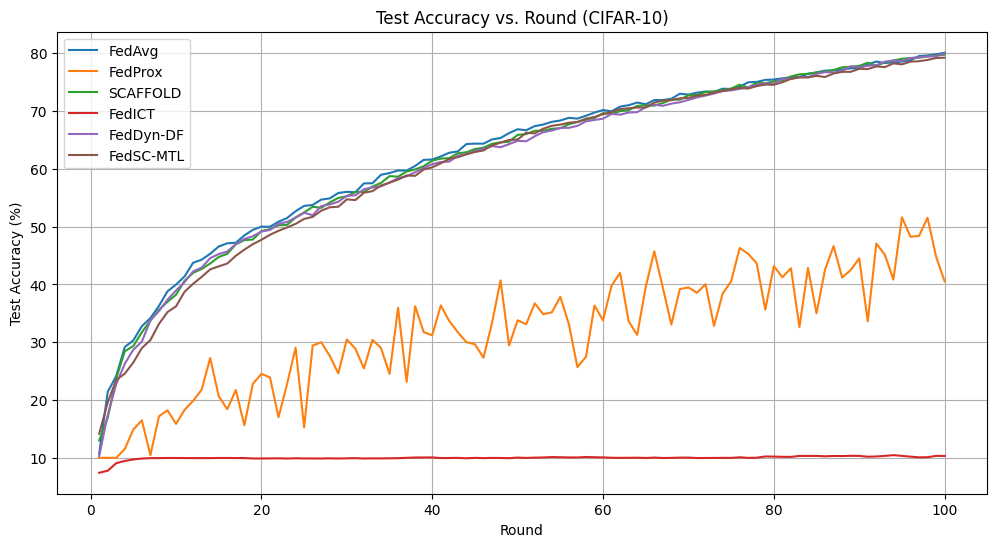

In [1]:
import matplotlib.pyplot as plt


fedavg_acc = [
    10.68, 21.40, 24.15, 29.17, 30.32, 32.77, 34.17, 36.28, 38.81, 39.96, 41.38, 43.74, 44.28, 45.30, 46.56, 47.11, 47.21, 48.47, 49.44, 49.99,
    49.97, 50.85, 51.48, 52.66, 53.58, 53.74, 54.67, 54.88, 55.81, 56.02, 55.95, 57.47, 57.50, 58.96, 59.26, 59.70, 59.68, 60.49, 61.54, 61.61,
    62.13, 62.78, 63.00, 64.28, 64.35, 64.35, 65.08, 65.33, 66.18, 66.84, 66.67, 67.38, 67.65, 68.12, 68.36, 68.82, 68.68, 69.17, 69.73, 70.16,
    69.94, 70.76, 71.00, 71.46, 71.17, 71.89, 71.89, 72.11, 72.99, 72.83, 73.17, 73.37, 73.28, 73.86, 73.80, 74.19, 74.97, 75.03, 75.38, 75.44,
    75.65, 75.84, 75.89, 76.43, 76.68, 76.98, 77.02, 77.17, 77.39, 77.42, 78.07, 78.55, 78.29, 78.41, 78.55, 78.77, 79.50, 79.61, 79.80, 80.08
]

# FedProx 数据
fedprox_acc = [
    10.00, 10.00, 10.00, 11.52, 14.91, 16.47, 10.44, 17.17, 18.22, 15.87, 18.30, 19.86, 21.78, 27.27, 20.65, 18.41, 21.72, 15.62, 22.82, 24.53,
    23.91, 17.03, 22.77, 29.05, 15.27, 29.42, 29.98, 27.64, 24.61, 30.48, 28.88, 25.47, 30.40, 29.01, 24.50, 35.96, 23.14, 36.22, 31.73, 31.20,
    36.36, 33.66, 31.71, 30.01, 29.64, 27.32, 33.32, 40.71, 29.45, 33.79, 33.10, 36.72, 34.84, 35.16, 37.85, 33.12, 25.70, 27.46, 36.34, 33.78,
    39.80, 41.99, 33.61, 31.26, 39.55, 45.73, 39.46, 33.06, 39.20, 39.47, 38.55, 40.03, 32.82, 38.39, 40.54, 46.29, 45.29, 43.62, 35.63, 43.17,
    41.23, 42.79, 32.62, 42.84, 35.01, 42.59, 46.62, 41.18, 42.48, 44.49, 33.60, 47.06, 45.14, 40.84, 51.61, 48.25, 48.38, 51.54, 44.81, 40.50
]

# SCAFFOLD 数据
scaffold_acc = [
    13.00, 16.93, 23.78, 28.44, 29.34, 31.72, 33.74, 35.58, 36.99, 38.21, 40.63, 42.00, 42.66, 43.62, 44.74, 45.29, 46.92, 47.66, 47.76, 49.23,
    49.56, 50.22, 50.30, 51.57, 52.46, 53.42, 53.25, 54.18, 54.96, 55.24, 55.98, 56.01, 56.92, 57.56, 58.73, 58.64, 59.52, 59.89, 60.45, 61.41,
    61.76, 61.85, 62.68, 62.86, 63.42, 63.65, 64.32, 64.57, 64.69, 65.87, 66.00, 66.58, 66.58, 66.92, 67.02, 67.70, 68.11, 68.51, 68.82, 69.62,
    69.47, 69.98, 70.15, 70.88, 71.00, 70.92, 71.37, 71.98, 71.96, 72.74, 72.77, 73.27, 73.40, 73.63, 73.88, 74.55, 74.06, 74.89, 74.79, 75.16,
    75.26, 75.97, 76.34, 76.43, 76.65, 76.83, 77.08, 77.56, 77.63, 77.81, 78.35, 77.82, 78.40, 78.74, 79.03, 79.16, 79.22, 79.43, 79.61, 79.74
]

fedict_acc = [
    7.42, 7.76, 9.07, 9.46, 9.72, 9.87, 9.95, 9.95, 9.97, 9.97, 
    9.96, 9.95, 9.95, 9.95, 9.97, 9.97, 9.96, 9.96, 9.89, 9.88,
    9.90, 9.91, 9.88, 9.92, 9.89, 9.89, 9.88, 9.91, 9.88, 9.91,
    9.94, 9.88, 9.90, 9.90, 9.92, 9.94, 10.00, 10.05, 10.06, 10.07,
    9.96, 9.97, 9.99, 9.92, 9.99, 9.95, 9.98, 9.97, 9.94, 10.04,
    9.98, 10.03, 10.06, 10.13, 10.10, 10.07, 10.06, 10.14, 10.10, 10.07,
    10.01, 9.99, 10.00, 10.02, 9.97, 10.04, 9.97, 9.99, 10.03, 10.04,
    9.96, 9.97, 9.98, 9.99, 9.99, 10.09, 9.99, 10.02, 10.23, 10.21,
    10.17, 10.16, 10.33, 10.32, 10.33, 10.26, 10.32, 10.30, 10.35, 10.33,
    10.19, 10.23, 10.33, 10.46, 10.33, 10.20, 10.08, 10.10, 10.34, 10.32
]

feddyn_df_acc = [
    10.29, 17.43, 22.75, 26.28, 28.70, 30.10, 33.80, 35.39, 37.35, 38.95,
    40.40, 42.23, 42.92, 44.54, 45.25, 45.69, 46.98, 47.87, 48.33, 49.15,
    49.42, 50.47, 50.81, 51.55, 52.40, 51.97, 53.54, 53.84, 54.30, 55.32,
    55.42, 56.46, 56.77, 56.96, 57.61, 58.40, 58.69, 59.41, 60.16, 60.80,
    61.18, 61.25, 62.26, 62.54, 63.09, 63.46, 63.93, 63.73, 64.27, 64.84,
    64.76, 65.62, 66.34, 66.62, 67.07, 67.09, 67.43, 68.22, 68.45, 68.67,
    69.49, 69.37, 69.73, 69.80, 70.68, 71.11, 70.89, 71.27, 71.51, 71.92,
    72.35, 72.67, 73.01, 73.44, 73.57, 73.83, 74.12, 74.54, 74.78, 74.74,
    75.59, 75.56, 75.87, 75.87, 76.41, 76.73, 76.65, 76.92, 77.75, 77.56,
    77.83, 77.91, 78.53, 78.72, 78.65, 79.16, 79.28, 79.43, 79.47, 79.99
]

fedsc_mtl_acc = [
    14.16, 19.58, 23.48, 24.56, 26.50, 28.99, 30.37, 33.16, 35.21, 36.20,
    38.73, 40.10, 41.30, 42.60, 43.12, 43.61, 44.95, 46.01, 46.96, 47.72,
    48.58, 49.27, 49.86, 50.47, 51.33, 51.68, 52.75, 53.34, 53.43, 54.71,
    54.59, 55.86, 56.13, 57.11, 57.61, 58.12, 58.85, 58.78, 59.88, 60.25,
    60.95, 61.71, 62.00, 62.50, 62.90, 63.18, 64.04, 64.53, 64.99, 65.06,
    66.24, 66.12, 66.94, 67.44, 67.64, 67.97, 68.09, 68.67, 68.95, 69.46,
    69.79, 70.33, 70.47, 70.60, 70.59, 71.47, 71.78, 71.88, 72.19, 72.27,
    72.65, 72.78, 73.18, 73.47, 73.75, 73.99, 73.88, 74.30, 74.57, 74.53,
    74.97, 75.56, 75.81, 75.80, 76.08, 75.88, 76.49, 76.77, 76.78, 77.30,
    77.25, 77.71, 77.59, 78.24, 78.07, 78.54, 78.61, 78.83, 79.17, 79.22
]



rounds = list(range(1, 101))

plt.figure(figsize=(12, 6))
plt.plot(rounds, fedavg_acc, label='FedAvg')
plt.plot(rounds, fedprox_acc, label='FedProx')
plt.plot(rounds, scaffold_acc, label='SCAFFOLD')
plt.plot(rounds, fedict_acc, label='FedICT')
plt.plot(rounds, feddyn_df_acc, label='FedDyn-DF')
plt.plot(rounds, fedsc_mtl_acc, label='FedSC-MTL')

plt.xlabel('Round')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs. Round (CIFAR-10)')
plt.legend()
plt.grid(True)
plt.show()
